In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
train_df = pd.read_csv('train.csv')                 #Add this block while submission
test_df = pd.read_csv('test.csv')

<ipython-input-3-99f69da54473>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [4]:
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print("Missing Values:\n", train_df.isnull().sum().sort_values(ascending=False).head(10))
print("\nSample Data:")
display(train_df.head())

Train Shape: (446075, 83)
Test Shape: (89215, 82)
Missing Values:
 CheatingDetectionMode    445976
CPUPerformanceClass      444231
GameClientID             424298
InternalTestingFlag      370454
BatteryType              316802
EarlyAccessProgram       283264
WIMBootFlag              282898
FraudDetectionStatus     158878
ISP_ID                   137488
SecureModeEnabled         26689
dtype: int64

Sample Data:


,PlayerID,GameName,GameVersion,AntiCheatVersion,SecuritySignatureVersion,BetaTesterFlag,RealTimeProtectionStatus,PassiveModeFlag,GameClientID,AntiCheatStatus,...,FirmwareVersionID,SecureBootEnabled,WIMBootFlag,VirtualMachineFlag,TouchScreenFlag,StylusSupportFlag,AlwaysOnFlag,GamerFlag,PlayerRegionID,CheatingFlag
0,ec1e79058196315dbc901dafa0fa3c55,warzone,1.1.15100.1,4.18.1807.18075,1.273.1826.0,0,7.0,0,NaN,53447.0,...,48686.0,1,NaN,0.0,0,0,0.0,1.0,11.0,0
1,5f74bc962b8d730e67ad94007d10d1e4,warzone,1.1.15100.1,4.9.10586.1106,1.273.461.0,0,7.0,0,NaN,6630.0,...,60549.0,1,0.0,0.0,0,0,1.0,0.0,12.0,0
2,146ffbf61a5580cbd64b7eec1839d450,warzone,1.1.15100.1,4.18.1806.18062,1.273.488.0,0,7.0,0,NaN,53447.0,...,45534.0,0,NaN,0.0,0,0,0.0,1.0,12.0,1
3,ddba4acd363398e8cd5dc2a42aa2c213,warzone,1.1.15200.1,4.8.10240.17443,1.275.590.0,0,7.0,0,NaN,53447.0,...,64709.0,0,0.0,0.0,0,0,0.0,1.0,11.0,0
4,8b485185720c29502e2ec51ed7b9280e,warzone,1.1.15100.1,4.18.1807.18075,1.273.1253.0,0,7.0,0,NaN,47238.0,...,33118.0,1,0.0,0.0,0,0,0.0,0.0,2.0,0


In [5]:
train = train_df.copy()
test = test_df.copy()

In [6]:
train_df = train_df.drop('PlayerID', axis=1)
test_df = test_df.drop('PlayerID', axis=1)

In [7]:
# Handle missing values with median
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if col in train_df.columns and col in test_df.columns:
        train_median = train_df[col].median()
        train_df[col] = train_df[col].fillna(train_median)
        test_df[col] = test_df[col].fillna(train_median)

In [ ]:
# See all the feature columns
print(train_df.columns.tolist())

['GameName', 'GameVersion', 'AntiCheatVersion', 'SecuritySignatureVersion', 'BetaTesterFlag', 'RealTimeProtectionStatus', 'PassiveModeFlag', 'GameClientID', 'AntiCheatStatus', 'SecurityToolsInstalled', 'SecurityToolsEnabled', 'SecureHardwareFlag', 'PlayerCountryID', 'PlayerCityID', 'ISP_ID', 'GeoRegionID', 'LanguageSetting', 'GamingPlatform', 'CPUArchitecture', 'OSVersion', 'OSBuildVersion', 'OSFeatureSet', 'OSReleaseType', 'OSBuildDetails', 'OSEdition', 'AntiCheatProtectionEnabled', 'AutomaticDataSharing', 'CheatingDetectionMode', 'SecureModeEnabled', 'EmbeddedBrowserVersion', 'FraudDetectionStatus', 'FirewallEnabled', 'UserAccessControlLevel', 'DeviceType', 'DeviceFamily', 'DeviceManufacturerID', 'DeviceModelID', 'CPUCoreCount', 'CPUManufacturerID', 'CPUModelID', 'CPUPerformanceClass', 'StorageCapacity', 'StorageType', 'SystemPartitionSize', 'HasDiskDrive', 'RAMSize', 'ChassisType', 'ScreenSize', 'ScreenResolutionWidth', 'ScreenResolutionHeight', 'PowerMode', 'BatteryType', 'BatteryC

In [ ]:
# Encode all categorical variables FIRST before any feature engineering
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if col in test_df.columns:
        combined_values = pd.concat([train_df[col], test_df[col]]).unique()
        value_to_int = {val: i for i, val in enumerate(combined_values)}

        train_df[col] = train_df[col].map(value_to_int)
        test_df[col] = test_df[col].map(value_to_int)
    else:
        print(f"Warning: Column '{col}' not found in test_df. Skipping.")

In [ ]:
# Ensure all columns are numeric for feature engineering
for col in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[col]):
        print(f"Converting non-numeric column {col} to numeric")
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_categories = set(test_df[col].unique())
            train_categories = set(le.classes_)
            unknown = test_categories - train_categories
            if unknown:
                print(f"Found unknown categories in test set for {col}")
                for unk in unknown:
                    test_df.loc[test_df[col] == unk, col] = le.classes_[0]
            test_df[col] = le.transform(test_df[col].astype(str))

In [ ]:
# Security features
if ('AntiCheatStatus' in train_df.columns and
    'SecurityToolsInstalled' in train_df.columns and
    'AntiCheatProtectionEnabled' in train_df.columns):
    train_df['SecurityScore'] = (                                 # Simple adding performed here
        train_df['AntiCheatStatus'] +
        train_df['SecurityToolsInstalled'] +
        train_df['AntiCheatProtectionEnabled']
    )
    test_df['SecurityScore'] = (
        test_df['AntiCheatStatus'] +
        test_df['SecurityToolsInstalled'] +
        test_df['AntiCheatProtectionEnabled']
    )

In [15]:
# Safe binary feature creations for suspicious configurations
if 'VirtualMachineFlag' in train_df.columns and 'AntiCheatProtectionEnabled' in train_df.columns:
    train_df['VM_NoProtection'] = ((train_df['VirtualMachineFlag'] == 1) &
                                  (train_df['AntiCheatProtectionEnabled'] == 0)).astype(int)
    test_df['VM_NoProtection'] = ((test_df['VirtualMachineFlag'] == 1) &
                                 (test_df['AntiCheatProtectionEnabled'] == 0)).astype(int)

In [16]:
# Hardware capability indicators
if 'CPUCoreCount' in train_df.columns and 'RAMSize' in train_df.columns:
    # Simple multiplication of key hardware specs
    train_df['HardwarePower'] = train_df['CPUCoreCount'] * train_df['RAMSize']
    test_df['HardwarePower'] = test_df['CPUCoreCount'] * test_df['RAMSize']

In [17]:
# OS-related features
if 'OSVersion' in train_df.columns and 'OSBuildVersion' in train_df.columns:
    # Simple ratio of two OS-related columns
    train_df['OSVersionRatio'] = train_df['OSVersion'] / (train_df['OSBuildVersion'] + 1)
    test_df['OSVersionRatio'] = test_df['OSVersion'] / (test_df['OSBuildVersion'] + 1)

In [ ]:
# Create gaming platform
if 'GamingPlatform' in train_df.columns and 'PlayerRegionID' in train_df.columns:
    # Simple interaction of platform and region
    train_df['PlatformRegion'] = train_df['GamingPlatform'] * train_df['PlayerRegionID']
    test_df['PlatformRegion'] = test_df['GamingPlatform'] * test_df['PlayerRegionID']

In [19]:
target = 'CheatingFlag'
X = train_df.drop(columns=[target])
y = train_df[target]
X_test = test_df.copy()

In [20]:
# Create train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
print("Training model with optimized parameters for large dataset")
clf = RandomForestClassifier(
    n_estimators=100,    
    max_depth=10,         
    min_samples_split=10,  
    min_samples_leaf=4,   
    max_features='sqrt',   
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1             
)

Training model with optimized parameters for large dataset


In [ ]:
# Since it is a very large datasets, we use a sample for training
if X_train.shape[0] > 100000:  
    print(f"Training on a 100k sample of {X_train.shape[0]} rows for better performance")
    sample_idx = np.random.choice(X_train.shape[0], 100000, replace=False)
    X_train_sample = X_train[sample_idx]
    y_train_sample = y_train.iloc[sample_idx]
    clf.fit(X_train_sample, y_train_sample)
else:
    clf.fit(X_train, y_train)

Training on a 100k sample of 356860 rows for better performance


In [24]:
# Model evaluation
val_preds = clf.predict(X_val)
acc = accuracy_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds)
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.6212
Validation F1 Score: 0.6498


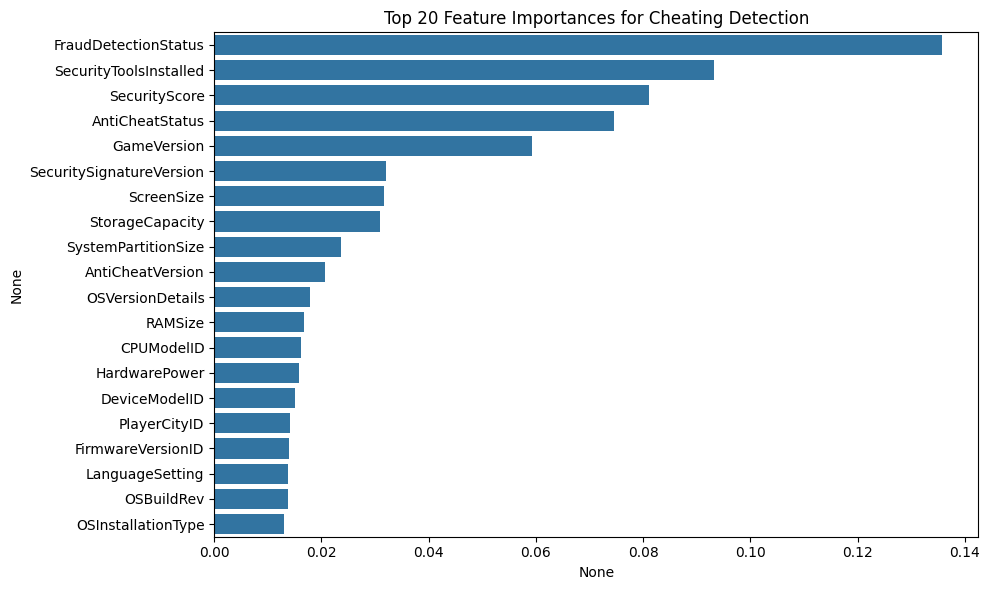

In [ ]:
# Feature importance visualization
feature_names = X.columns.tolist()
feature_importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title("Top 20 Feature Importances for Cheating Detection")
plt.tight_layout()
plt.show()

In [26]:
# Generate predictions
test_preds = clf.predict(X_test)
submission = pd.DataFrame({"PlayerID": test["PlayerID"], "CheatingFlag": test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
